In [11]:
!pip install tensorflow -q
!pip install keras-tuner -q
!pip install kaggle -q
!pip install scikeras -q

In [12]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Rescaling, Lambda, MaxPooling2D, Conv2D, AveragePooling2D, Activation, Reshape, UpSampling2D
from keras import backend as K
from keras import applications
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
from sklearn.metrics import roc_auc_score
import os
from google.colab import files
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


In [13]:
test_alpha = 0.2
my_seed = 19
batch_size = 32
img_height = 256
img_width = 256

In [14]:
!ls -lha kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download juanjosemontenegro/ecografashigado

-rw-r--r-- 1 root root 74 Nov 24 23:54 kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/juanjosemontenegro/ecografashigado
License(s): unknown
 99% 1.31G/1.31G [00:09<00:00, 249MB/s]
100% 1.31G/1.31G [00:09<00:00, 146MB/s]


In [15]:
ROOT_DIR = '/content'
DATASET_NAME = 'ecografashigado'

In [16]:
%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

/content
mkdir: cannot create directory ‘/ecografashigado’: File exists
Archive:  ecografashigado.zip
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.42.43 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.42.58 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.43.10 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.43.25 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.43.34 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.43.46 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/57 2024-11-19 a la(s) 8.43.55 a. m..jpg  
  inflating: /content/ecografashigado/OneDrive_2024-11-22/Higados enfermos/58,1

In [17]:
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}/Higados Sanos"
print(DATA_DIR)

/content/ecografashigado/Higados Sanos


# Preprocessing data

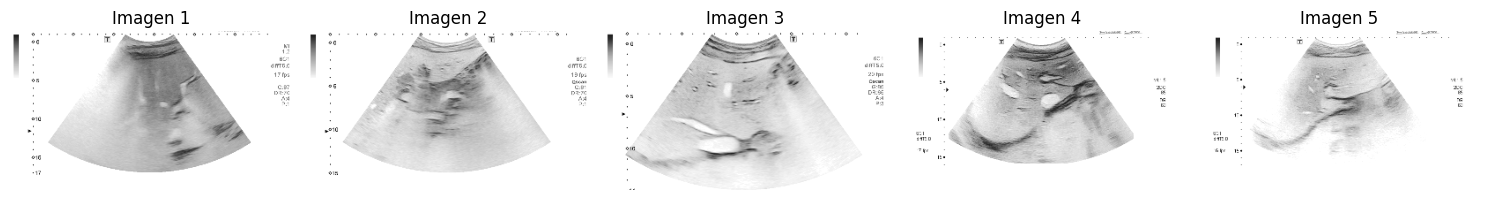

In [31]:
show_sample_images(images, num_samples=5)


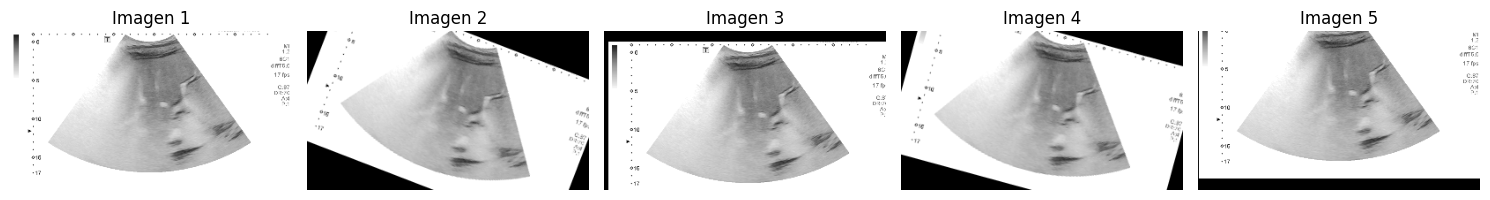

Total de imágenes generadas: 4501


In [32]:
def preprocess_image(image_path, target_size=(320, 180)):
    """
    Preprocesa una imagen: convierte a escala de grises, redimensiona y normaliza.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"No se pudo cargar la imagen en {image_path}")
    image_resized = cv2.resize(image, target_size)
    image_normalized = 1-(image_resized / 255.0)
    return image_normalized

def augment_image(image):
    """
    Aplica técnicas de aumentación de datos a una imagen.
    """
    augmented_images = []

    # Rotación aleatoria
    angle = random.uniform(-30, 30)  # Rotar entre -30 y 30 grados
    rows, cols = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    augmented_images.append(rotated_image)

    # Traslación
    translation_matrix = np.float32([[1, 0, random.randint(-20, 20)], [0, 1, random.randint(-20, 20)]])
    translated_image = cv2.warpAffine(image, translation_matrix, (cols, rows))
    augmented_images.append(translated_image)



    return augmented_images

def preprocess_and_augment_dataset(input_dir, target_size=(320, 180), augment_count=5):
    """
    Preprocesa y aplica aumentación de datos a todas las imágenes en un directorio.
    Devuelve un array de imágenes augmentadas.
    """
    all_images = []  # Lista para almacenar todas las imágenes augmentadas

    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                input_path = os.path.join(root, file)

                try:
                    # Preprocesar imagen
                    image = preprocess_image(input_path, target_size)
                    all_images.append(image)  # Agregar la original

                    # Aumentar datos
                    for _ in range(augment_count):
                        augmented_images = augment_image(image)
                        all_images.extend(augmented_images)
                except Exception as e:
                    print(f"Error procesando {input_path}: {e}")

    return np.array(all_images)

def show_sample_images(images_array, num_samples=5):
    """
    Muestra una muestra de imágenes.
    """
    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(images_array))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images_array[i], cmap='gray')
        plt.title(f"Imagen {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
input_path = DATA_DIR

# Preprocesar y aumentar el dataset
images = preprocess_and_augment_dataset(input_path, target_size=(320, 180), augment_count=3)

# Mostrar una muestra de las imágenes aumentadas
show_sample_images(images, num_samples=5)

print(f"Total de imágenes generadas: {len(images)}")

In [33]:
train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

print(f"Conjunto de entrenamiento: {train_images.shape}")
print(f"Conjunto de validación: {val_images.shape}")

Conjunto de entrenamiento: (3600, 180, 320)
Conjunto de validación: (901, 180, 320)


In [34]:
input_img = Input(shape=(180, 320, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Modelo
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenamiento
autoencoder.fit(train_images, train_images, epochs=20, batch_size=64, validation_data=(val_images, val_images))

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0560 - val_loss: 0.0072
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0040 - val_loss: 0.0071
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 12/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


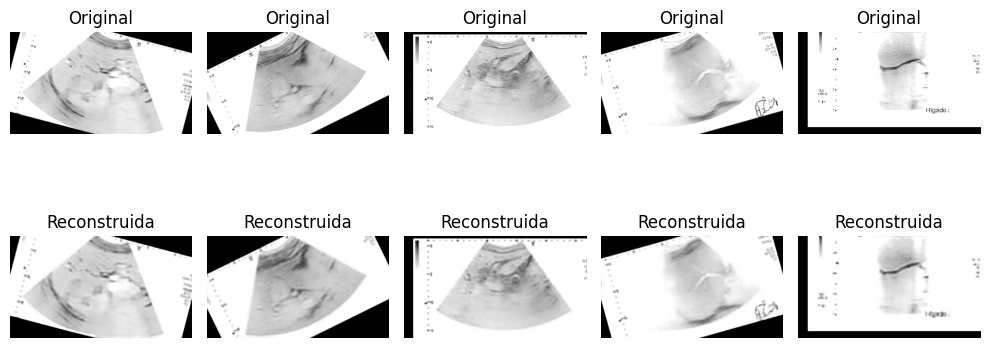

In [35]:
decoded_images = autoencoder.predict(val_images)

n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(val_images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].squeeze(), cmap='gray')
    plt.title("Reconstruida")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [43]:
def calculate_reconstruction_error(original, reconstructed):
    reconstructed = reconstructed.squeeze()
    return np.mean((original - reconstructed)**2)

reconstructed_images = autoencoder.predict(images)
# Cálculo de errores
reconstruction_errors = [calculate_reconstruction_error(original, reconstructed)
                         for original, reconstructed in zip(images, reconstructed_images)]
# Definir el umbral como el percentil 95
threshold = np.percentile(reconstruction_errors, 98)
print(f"Umbral de error de reconstrucción: {threshold}")

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Umbral de error de reconstrucción: 0.0026888452667952764


In [37]:
def classify_image(image, autoencoder, threshold):
    reconstructed_image = autoencoder.predict(image)[0]
    error = calculate_reconstruction_error(image, reconstructed_image)
    return "Anómala" if error > threshold else "Normal"

In [38]:
Model.summary(autoencoder)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 320, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 180, 320, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 160, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 90, 160, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 45, 80, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 80, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 90, 160, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 90, 160, 32)         │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 180, 320, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 320, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 223,493 (873.02 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 148,996 (582.02 KB)

In [39]:

def load_images_from_directory(directory, target_size=(320, 180)):

    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    if not image_files:
        print("No images found in the directory.")
        return None

    images = []
    for filename in image_files:
        img_path = os.path.join(directory, filename)
        try:
            image = preprocess_image(img_path, target_size)
            images.append(image)
        except Exception as e:
            print(f"Error processing image {filename}: {e}")

    if not images:  # Check if any images were successfully loaded
        print("No images could be loaded.")
        return None

    return np.array(images)

image_array = load_images_from_directory('/content/ecografashigado/Higados enfermos')

if image_array is not None:
    print(f"Shape of the image array: {image_array.shape}")


Shape of the image array: (501, 180, 320)


In [41]:
for image in image_array:
    image = image[..., np.newaxis]
    print(classify_image(image, autoencoder, threshold))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anómala
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

In [42]:
autoencoder.save('autoencoderNASHsnoAugmentation.h5')